<a href="https://colab.research.google.com/github/VarunSUK/ml-scd-detection/blob/main/Model_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 590 files belonging to 2 classes.
Found 236 files belonging to 2 classes.
Found 242 files belonging to 2 classes.
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.7564 - loss: 0.7695 - val_accuracy: 0.8220 - val_loss: 0.4914
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.7931 - loss: 0.5258 - val_accuracy: 0.8220 - val_loss: 0.4812
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.7735 - loss: 0.5428 - val_accuracy: 0.8220 - val_loss: 0.4876
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.7752 - loss: 0.5365 - val_accuracy: 0.8220 - val_loss: 0.4676
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.7678 - loss: 0.5420 - val_accuracy: 0.8220 - val_loss: 0.4652
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.7985 - loss: 0.4982 - val_accuracy: 0.8220 - val_loss: 0

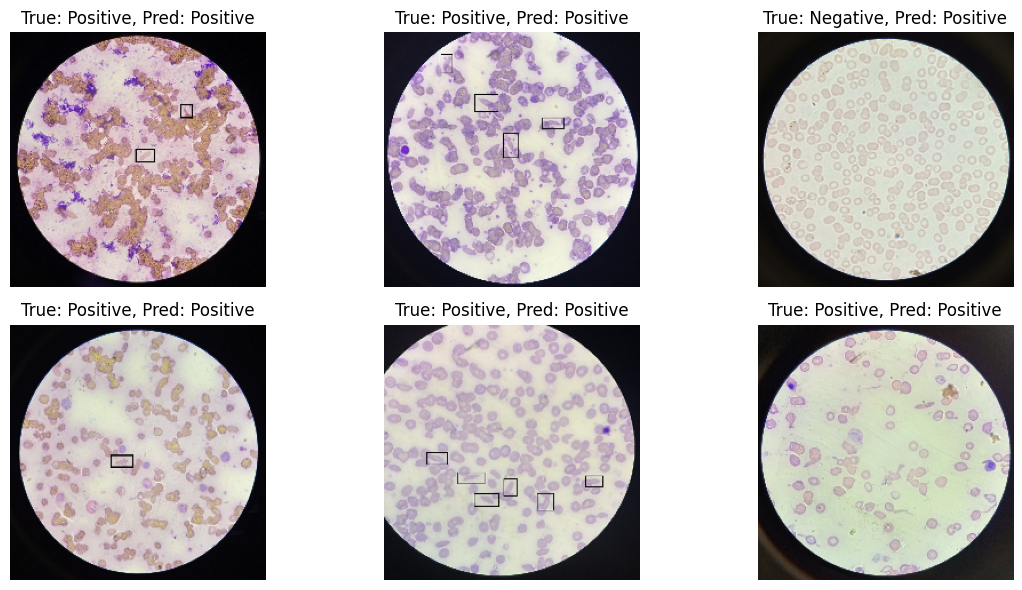

In [ ]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')


import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np


BATCH_SIZE = 32
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

project_root = '/content/drive/MyDrive/Colab Notebooks/Sickle Cell Project'
target_base = os.path.join(project_root, 'Dataset')


train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(target_base, 'train'),
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(target_base, 'val'),
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(target_base, 'test'),
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
class_names = test_ds_raw.class_names

# --- Prefetch for performance ---
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds_raw.prefetch(buffer_size=AUTOTUNE)

# --- Data augmentation ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
], name="data_augmentation")

preprocessing = layers.Rescaling(1./255, name="rescale")


model = models.Sequential([
    data_augmentation,
    preprocessing,

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)


test_loss, test_acc = model.evaluate(test_ds)
print(f'\nTest Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds = tf.round(preds).numpy().flatten()

    plt.figure(figsize=(12, 6))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = int(labels[i])
        pred = int(preds[i])
        plt.title(f"True: {class_names[label]}, Pred: {class_names[pred]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()



In [ ]:
import tensorflow as tf

from tensorflow.keras import layers

# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

# Preprocessing Layer (Rescaling pixel values)
preprocessing = layers.Rescaling(1./255)


In [ ]:
#model.compile(
    #optimizer='adam',
    #loss='binary_crossentropy',
    #metrics=['accuracy']
#)


In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.8707 - loss: 0.3832

Test Accuracy: 0.8471
Test Loss: 0.4110


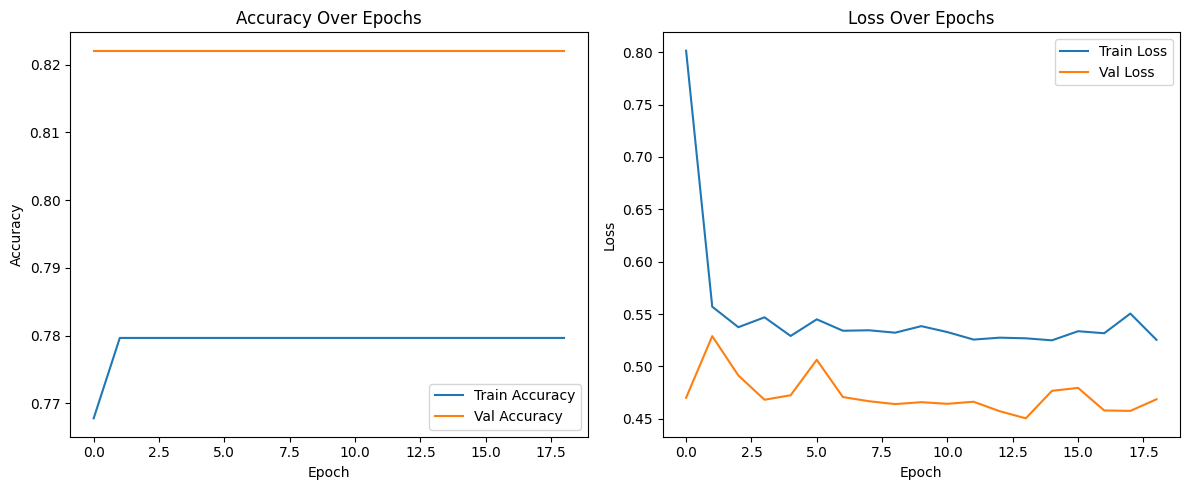

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Sickle Cell Project/sickle_model.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


<Figure size 600x600 with 0 Axes>

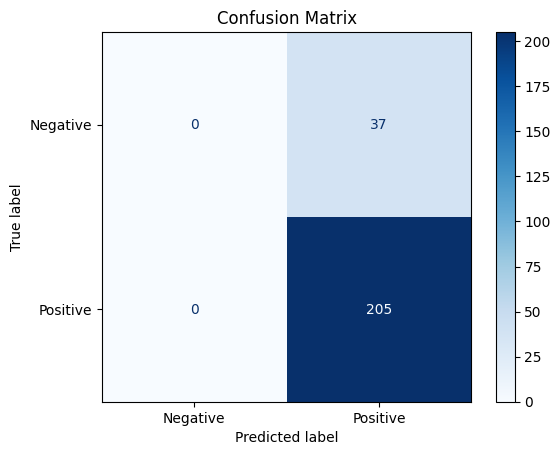


Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        37
    Positive       0.85      1.00      0.92       205

    accuracy                           0.85       242
   macro avg       0.42      0.50      0.46       242
weighted avg       0.72      0.85      0.78       242



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = tf.round(preds).numpy().flatten()

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
import os

for split in ['train', 'val', 'test']:
    path = os.path.join(target_base, split)
    print(f"\n{split.upper()}:")
    for cls in os.listdir(path):
        count = len(os.listdir(os.path.join(path, cls)))
        print(f"  {cls}: {count}")



TRAIN:
  Positive: 460
  Negative: 130

VAL:
  Positive: 194
  Negative: 42

TEST:
  Positive: 205
  Negative: 37


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Extract labels from train_ds
y_train = []
for _, labels in train_ds.unbatch():
    y_train.append(int(labels.numpy().item()))
y_train = np.array(y_train)


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)



/tmp/ipython-input-18-2411634995.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_train.append(int(labels.numpy()))


Class Weights: {0: np.float64(2.269230769230769), 1: np.float64(0.6413043478260869)}


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weights
)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.6416 - loss: 0.4773 - val_accuracy: 0.6356 - val_loss: 0.5067
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.6269 - loss: 0.4886 - val_accuracy: 0.6822 - val_loss: 0.5061
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.6499 - loss: 0.4710 - val_accuracy: 0.6229 - val_loss: 0.6856
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.6288 - loss: 0.4572 - val_accuracy: 0.6907 - val_loss: 0.4879
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.6624 - loss: 0.4839 - val_accuracy: 0.6653 - val_loss: 0.5390
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.6704 - loss: 0.4519 - val_accuracy: 0.7331 - val_loss: 0.4349
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.6897 - loss: 0.4295 - val_accuracy: 0.6568 - val_loss: 0.5458
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.7140 - loss: 0.4593 - val_accuracy: 0.7839 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


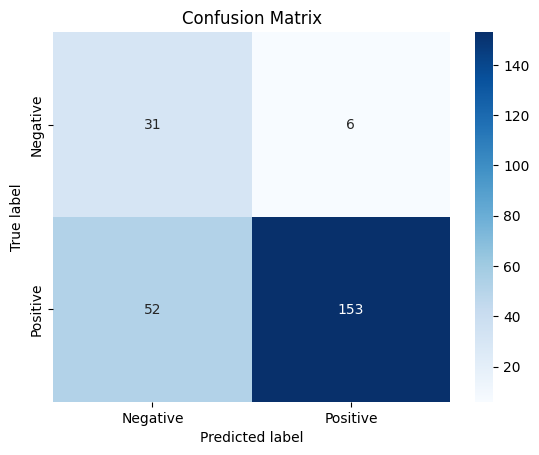

Classification Report:
               precision    recall  f1-score   support

    Negative       0.37      0.84      0.52        37
    Positive       0.96      0.75      0.84       205

    accuracy                           0.76       242
   macro avg       0.67      0.79      0.68       242
weighted avg       0.87      0.76      0.79       242



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images)
    preds = tf.round(preds).numpy().flatten()
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

#
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Constants
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

# Paths
project_root = '/content/drive/MyDrive/Colab Notebooks/Sickle Cell Project'
target_base = os.path.join(project_root, 'Dataset')

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(target_base, 'train'),
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(target_base, 'val'),
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(target_base, 'test'),
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Prefetching
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation + Preprocessing
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Compute class weights
y_train = np.concatenate([y.numpy().flatten() for x, y in train_ds])
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Class Weights:", class_weights)

# Load MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base for now

# Build full model
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop]
)

# Evaluate
loss, acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test Loss: {loss:.4f}")

# Predictions for confusion matrix
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_pred_probs = model.predict(test_ds).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

# AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
auc_score = roc_auc_score(y_true, y_pred_probs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend()
plt.grid()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 590 files belonging to 2 classes.
Found 236 files belonging to 2 classes.
Found 242 files belonging to 2 classes.
Class Weights: {0: np.float64(2.269230769230769), 1: np.float64(0.6413043478260869)}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5213 - loss: 0.7054 - val_accuracy: 0.7585 - val_loss: 0.4890
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7424 - loss: 0.5381 - val_accuracy: 0.8008 - val_loss: 0.4486
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8142 - loss: 0.4495 - val_accuracy: 0.8178 - val_loss: 0.4169
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.8287 - loss: 0.3555 - val_accuracy: 0.8475 - val_loss: 0.3394
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8120 - loss: 0.3669 - val_accuracy: 0.8771 - val_

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9297 - loss: 0.1888
Test Accuracy: 0.9215
Test Loss: 0.1850


8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


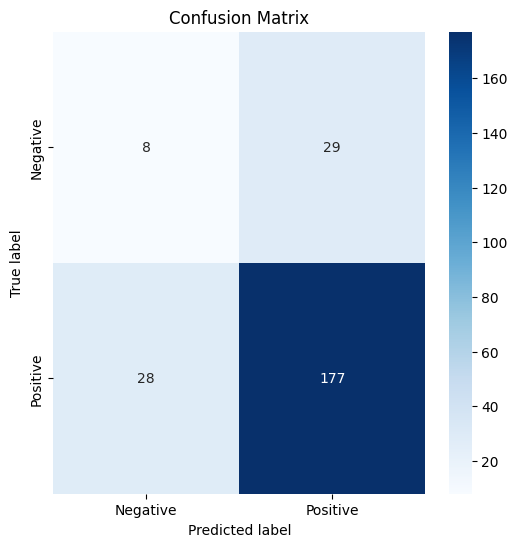

Classification Report:
              precision    recall  f1-score   support

    Negative       0.22      0.22      0.22        37
    Positive       0.86      0.86      0.86       205

    accuracy                           0.76       242
   macro avg       0.54      0.54      0.54       242
weighted avg       0.76      0.76      0.76       242



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 590 files belonging to 2 classes.
Found 236 files belonging to 2 classes.
Found 242 files belonging to 2 classes.
Class Weights: {0: 2.269230769230769, 1: 0.6413043478260869}
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5167 - loss: 0.7906 - val_accuracy: 0.7161 - val_loss: 0.5540
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7398 - loss: 0.5776 - val_accuracy: 0.7542 - val_loss: 0.5088
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.7617 - loss: 0.4830 - val_accuracy: 0.8644 - val_loss: 0.3382
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.8018 - loss: 0.4462 - val_accuracy: 0.8559 - val_loss: 0.3558
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.8281 - loss: 0.3567 - val_accuracy: 0.8941 - val_loss: 0.2765
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy

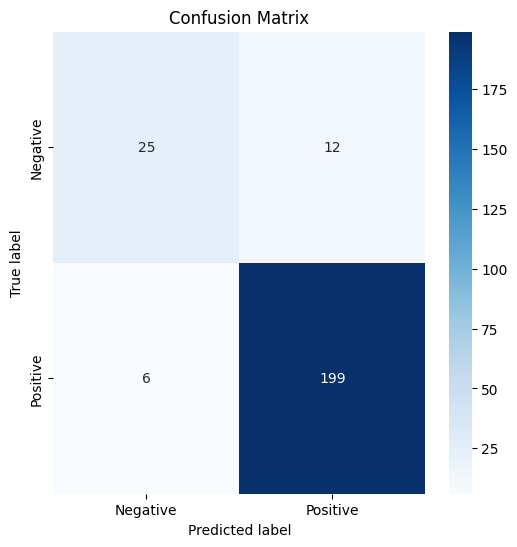


Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.68      0.74        37
    Positive       0.94      0.97      0.96       205

    accuracy                           0.93       242
   macro avg       0.87      0.82      0.85       242
weighted avg       0.92      0.93      0.92       242



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

# Paths
project_root = '/content/drive/MyDrive/Colab Notebooks/Sickle Cell Project'
target_base = os.path.join(project_root, 'Dataset')

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(target_base, 'train'),
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(target_base, 'val'),
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(target_base, 'test'),
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Compute class weights
y_train = np.concatenate([y.numpy().ravel() for x, y in train_ds], axis=0)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {int(k): float(v) for k, v in zip(np.unique(y_train), weights)}
print("Class Weights:", class_weights)

# Data augmentation and normalization
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])
preprocessing = layers.Rescaling(1./255)

# Build MobileNetV2-based model
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Fine-tune later if needed

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocessing(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train model
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weights
)

# Evaluate model
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Confusion Matrix + Classification Report
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0).astype(int)
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Sickle Cell Project/sickle_model.keras')

